In [1]:
%matplotlib inline

In [86]:
%run setup_environment.py
%run custom_tools.py
#%run ml_tools.py

current_conda_env = !echo $CONDA_DEFAULT_ENV
check_conda_env(current_conda_env[0])

Setup environment... done!


✅ <span style='color:green'>Working on **impact-annotator_env** conda environment.</span>

<Figure size 1000x400 with 0 Axes>

In [23]:
import sys
sys.path.append('/Users/pierreguilmin/anaconda3/envs/impact-annotator_env/lib/python3.6/site-packages')

In [5]:
import sys
sys.path

['',
 '/Users/pierreguilmin/anaconda3/lib/python36.zip',
 '/Users/pierreguilmin/anaconda3/lib/python3.6',
 '/Users/pierreguilmin/anaconda3/lib/python3.6/lib-dynload',
 '/Users/pierreguilmin/.local/lib/python3.6/site-packages',
 '/Users/pierreguilmin/anaconda3/lib/python3.6/site-packages',
 '/Users/pierreguilmin/anaconda3/lib/python3.6/site-packages/aeosa',
 '/Users/pierreguilmin/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/Users/pierreguilmin/.ipython']

In [1]:
!which python
!which ipython

/Users/pierreguilmin/anaconda3/envs/impact-annotator_env/bin/python
/Users/pierreguilmin/anaconda3/envs/impact-annotator_env/bin/ipython


# somatic vs non-somatic classification

In [41]:
impact = pd.read_csv('../../data/annotated_final_IMPACT_mutations_180508.txt', sep = '\t', low_memory = False)

# shuffle data
rng = np.random.RandomState(0)
permutation = rng.permutation(len(impact))
impact = impact.iloc[permutation]

impact.shape

(194211, 63)

## Feature processsing

### `is_somatic`

In [42]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [43]:
impact['is_somatic'] = impact.confidence_class != "UNLIKELY"
get_table(impact.is_somatic)

,count_,freq_
True,187012,96.3%
False,7199,3.7%


## Setup the train/test sets

In [9]:
label_feature_name = 'is_somatic'

In [72]:
print(impact[~impact.is_somatic].shape)
print(impact[impact.is_somatic].iloc[0:20000].shape)

impact_selected = pd.concat([impact[~impact.is_somatic],
                             impact[impact.is_somatic].iloc[0:20000]], ignore_index = True)
impact_selected.shape

(7199, 64)
(20000, 64)


(27199, 64)

### Choose features

In [73]:
feature_names = [
# 'Hugo_Symbol', 'Chromosome', 'Start_Position', 'End_Position', 'Consequence', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele2', 'Tumor_Sample_Barcode',
# 'cDNA_change', 'HGVSp_Short',
't_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count',
# 't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
#'confidence_class',
'sample_coverage',
#'mut_key',
#'VAG_VT', 'VAG_GENE', 'VAG_cDNA_CHANGE', 'VAG_PROTEIN_CHANGE', 'VAG_EFFECT',
'VEP_Consequence',
#'VEP_SYMBOL', 'VEP_HGVSc', 'VEP_HGVSp',
#'VEP_Amino_acids',
'VEP_VARIANT_CLASS',
#'VEP_EXON', 'VEP_INTRON',
'VEP_IMPACT',
'VEP_CLIN_SIG',
'VEP_COSMIC_CNT',
'VEP_gnomAD_AF',
#'sample_mut_key', 'patient_key',
'frequency_in_normals',
#'VEP_SIFT_class',
#'VEP_SIFT_score',
#'VEP_PolyPhen_class',
#'VEP_PolyPhen_score',
'VEP_in_dbSNP',
'VEP_gnomAD_total_AF_AFR',
'VEP_gnomAD_total_AF_AMR',
'VEP_gnomAD_total_AF_ASJ',
'VEP_gnomAD_total_AF_EAS',
'VEP_gnomAD_total_AF_FIN',
'VEP_gnomAD_total_AF_NFE',
'VEP_gnomAD_total_AF_OTH',
'VEP_gnomAD_total_AF_max',
'VEP_gnomAD_total_AF',
'Kaviar_AF',
#'is_a_hotspot',
#'is_a_3d_hotspot',
#'oncogenic',
'gene_type',
label_feature_name
]

categorical_features_names = [
'VEP_Consequence',
#'VEP_Amino_acids',
'VEP_VARIANT_CLASS',
'VEP_IMPACT',
'VEP_CLIN_SIG',
#'VEP_SIFT_class',
#'VEP_PolyPhen_class',
'VEP_in_dbSNP',
'gene_type',
]

In [74]:
impact_selected = impact_selected[feature_names].dropna()
impact_selected.shape

(27199, 27)

In [75]:
impact_selected = pd.get_dummies(impact_selected, columns = categorical_features_names, sparse = True)
impact_selected.shape

(27199, 46)

### Split features from label

In [76]:
X = impact_selected.drop(label_feature_name, axis = 1) # features matrix X: [n_samples, n_features]
y = impact_selected[label_feature_name]                # target array y: n_samples
print(X.shape)
print(y.shape)

(27199, 45)
(27199,)


In [77]:
get_table(y)

,count_,freq_
True,20000,73.5%
False,7199,26.5%


## Main functions

In [78]:
from sklearn.model_selection import StratifiedShuffleSplit

# returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)

In [90]:
from sklearn.model_selection import GridSearchCV

# inner cross validation on hyperparameters
inner_cv_strategy = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 1)

In [79]:
i = 0
for train_index, test_index in cv_strategy.split(X, y):
    print("Fold %d :\n" % i,
          "  → train_index (%5d elements) %s\n" % (len(train_index), str(train_index)),
          "  → test_index  (%5d elements) %s" % (len(test_index), str(test_index)))
    i += 1

Fold 0 :
   → train_index (21759 elements) [22384  9014  2951 ... 12325  1992 23421]
   → test_index  ( 5440 elements) [25681   326  3615 ...  8464 16587 15818]
Fold 1 :
   → train_index (21759 elements) [ 8628 18579  1037 ... 20352  6647 17410]
   → test_index  ( 5440 elements) [20063 12561 14191 ...  4164   710 20468]
Fold 2 :
   → train_index (21759 elements) [ 1441 21283 25746 ... 17064 10776  1673]
   → test_index  ( 5440 elements) [ 7412 17231 19251 ... 23327 12897  1196]
Fold 3 :
   → train_index (21759 elements) [16914 18024 19701 ...  7224 10318 20742]
   → test_index  ( 5440 elements) [  480  6279 17232 ...  6841 17050  9946]
Fold 4 :
   → train_index (21759 elements) [  141  3724  7643 ...  9259 10806 12796]
   → test_index  ( 5440 elements) [23573 25413 16572 ... 21823  5713  2985]


## Dummy

### Uniform


## Mean accuracy: 0.50 ± 0.01
## Mean ROC AUC : 0.50 ± 0.00


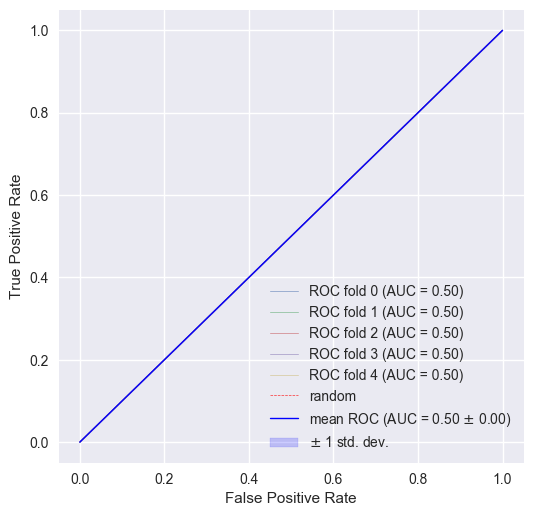

In [81]:
from sklearn.dummy import DummyClassifier

model_uniform = DummyClassifier(strategy = 'uniform', random_state = 1)
# generates predictions uniformly at random
#   → expected accuracy: 0.5 | expected AUC: 0.5

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_uniform, X, y, cv_strategy, plot_roc = True, ax = ax)

### Most Frequent


## Mean accuracy: 0.74 ± 0.00
## Mean ROC AUC : 0.50 ± 0.00


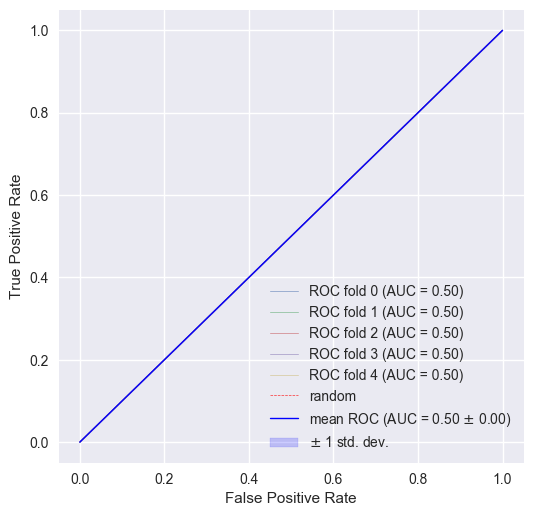

In [82]:
from sklearn.dummy import DummyClassifier

model_most_frequent = DummyClassifier(strategy = 'most_frequent', random_state = 1)
# always predicts the most frequent label in the training set
#   → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_most_frequent, X, y, cv_strategy, plot_roc = True, ax = ax)

## Gaussian Naive Bayes


## Mean accuracy: 0.80 ± 0.01
## Mean ROC AUC : 0.80 ± 0.00


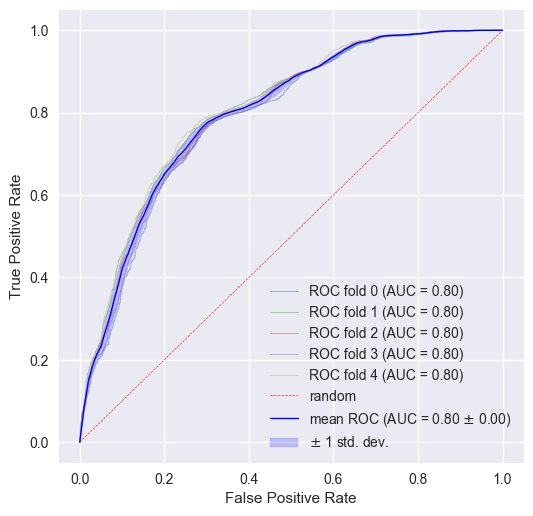

In [83]:
from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB()

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GaussianNB, X, y, cv_strategy, plot_roc = True, ax = ax)

In [84]:
#from sklearn.naive_bayes import ComplementNB

#model_ComplementNB = ComplementNB()

#fig, ax = plt.subplots(1, 1, figsize = (6, 6))
#run(model_ComplementNB, X, y, cv_strategy, plot_roc = True, ax = ax)

## Logistic Regression


## Mean accuracy: 0.84 ± 0.01
## Mean ROC AUC : 0.82 ± 0.00


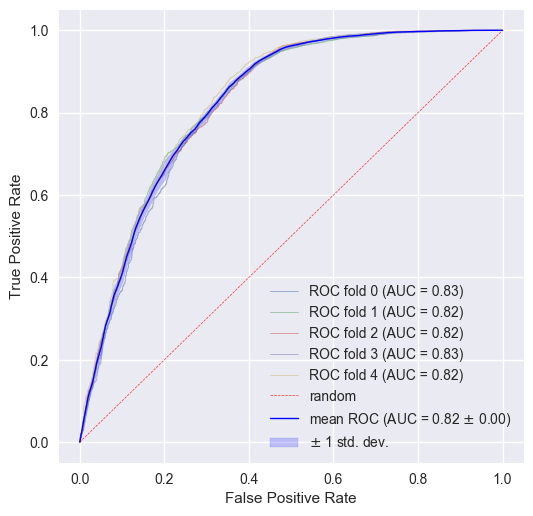

In [85]:
from sklearn.linear_model import LogisticRegressionCV

model_LogisticRegressionCV = LogisticRegressionCV(random_state = 1)
# Logistic Regression with builtin cross-validation to find out the optimal C parameter

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_LogisticRegressionCV, X, y, cv_strategy, plot_roc = True, ax = ax)

## K Nearest Neighbors

In [109]:
%run ml_tools.py

<Figure size 1000x400 with 0 Axes>

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [82.27s | 7.35s]
  → accuracy: [0.964 | 1.000]
  → ROC AUC : [0.728 | 1.000]
  → Best parameters : {'n_neighbors': 100, 'weights': 'distance'}
    0.64 ± 0.05 for {'n_neighbors': 10, 'weights': 'uniform'}
    0.64 ± 0.05 for {'n_neighbors': 10, 'weights': 'distance'}
    0.71 ± 0.06 for {'n_neighbors': 50, 'weights': 'uniform'}
    0.71 ± 0.06 for {'n_neighbors': 50, 'weights': 'distance'}
    0.71 ± 0.04 for {'n_neighbors': 100, 'weights': 'uniform'}
    0.72 ± 0.05 for {'n_neighbors': 100, 'weights': 'distance'}
Fold 1: [82.16s | 10.06s]
  → accuracy: [0.963 | 1.000]
  → ROC AUC : [0.768 | 1.000]
  → Best parameters : {'n_neighbors': 100, 'weights': 'distance'}
    0.66 ± 0.02 for {'n_neighbors': 10, 'weights': 'uniform'}
    0.66 ± 0.02 for {'n_neighbors': 10, 'weights': 'distance'}
    0.70 ± 0.03 for {'n_neighbors': 50, 'weights': 'uniform'}
    0

KeyboardInterrupt: 

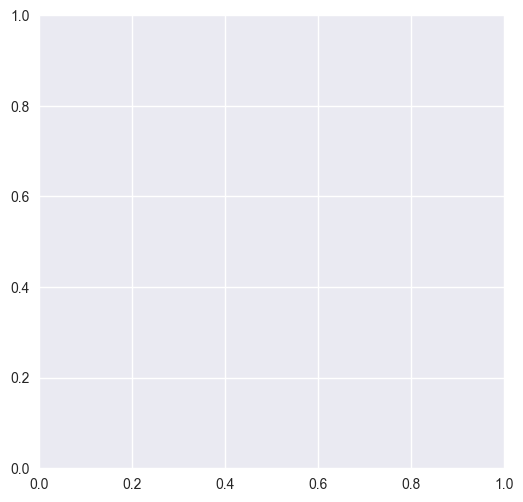

In [110]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters_grid = [
    {'n_neighbors': [10, 50, 100], 'weights': ['uniform', 'distance']}
]

model_GS_KNeighborsClassifier = GridSearchCV(KNeighborsClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_KNeighborsClassifier, X, y, cv_strategy, grid_search = True, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)

## Random Forest

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [27.21s | 0.72s]
  → accuracy: [0.88 | 0.93]
  → ROC AUC : [0.89 | 0.96]
  → Best parameters : {'max_depth': 20, 'n_estimators': 100}
    0.85 ± 0.00 for {'max_depth': 5, 'n_estimators': 10}
    0.86 ± 0.01 for {'max_depth': 5, 'n_estimators': 100}
    0.88 ± 0.00 for {'max_depth': 20, 'n_estimators': 10}
    0.89 ± 0.00 for {'max_depth': 20, 'n_estimators': 100}
Fold 1: [23.28s | 0.55s]
  → accuracy: [0.88 | 0.93]
  → ROC AUC : [0.90 | 0.96]
  → Best parameters : {'max_depth': 20, 'n_estimators': 100}
    0.85 ± 0.01 for {'max_depth': 5, 'n_estimators': 10}
    0.86 ± 0.01 for {'max_depth': 5, 'n_estimators': 100}
    0.88 ± 0.00 for {'max_depth': 20, 'n_estimators': 10}
    0.89 ± 0.00 for {'max_depth': 20, 'n_estimators': 100}
Fold 2: [19.95s | 0.60s]
  → accuracy: [0.88 | 0.93]
  → ROC AUC : [0.89 | 0.96]
  → Best parameters : {'max_depth': 20, 'n_

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,27.2086,0.721563,0.928489,0.884559,0.963548,0.891902,"{'max_depth': 20, 'n_estimators': 100}"
1,23.2829,0.550649,0.92826,0.880882,0.964089,0.90098,"{'max_depth': 20, 'n_estimators': 100}"
2,19.9501,0.598176,0.927984,0.878125,0.962924,0.887718,"{'max_depth': 20, 'n_estimators': 100}"
3,20.5403,0.509929,0.927938,0.879779,0.96433,0.891516,"{'max_depth': 20, 'n_estimators': 100}"
4,20.5687,0.609832,0.928489,0.886581,0.965444,0.896122,"{'max_depth': 20, 'n_estimators': 100}"


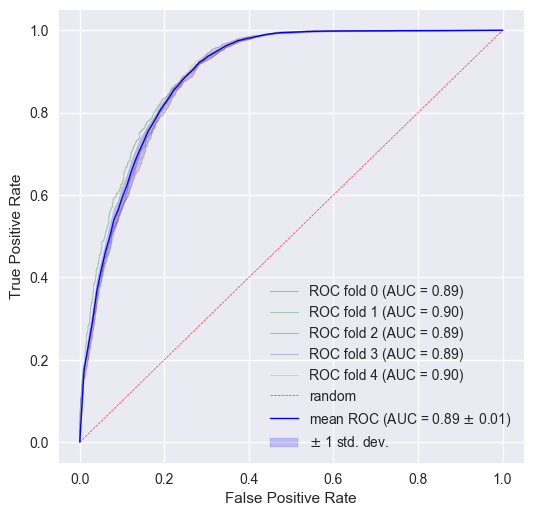

In [97]:
from sklearn.ensemble import RandomForestClassifier

parameters_grid = [
    {'n_estimators': [10, 100], 'max_depth': [5, 20]}
]

model_GS_RandomForestClassifier = GridSearchCV(RandomForestClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_RandomForestClassifier, X, y, cv_strategy, grid_search = True, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)


## Mean accuracy: 0.82 ± 0.01
## Mean ROC AUC : 0.77 ± 0.01


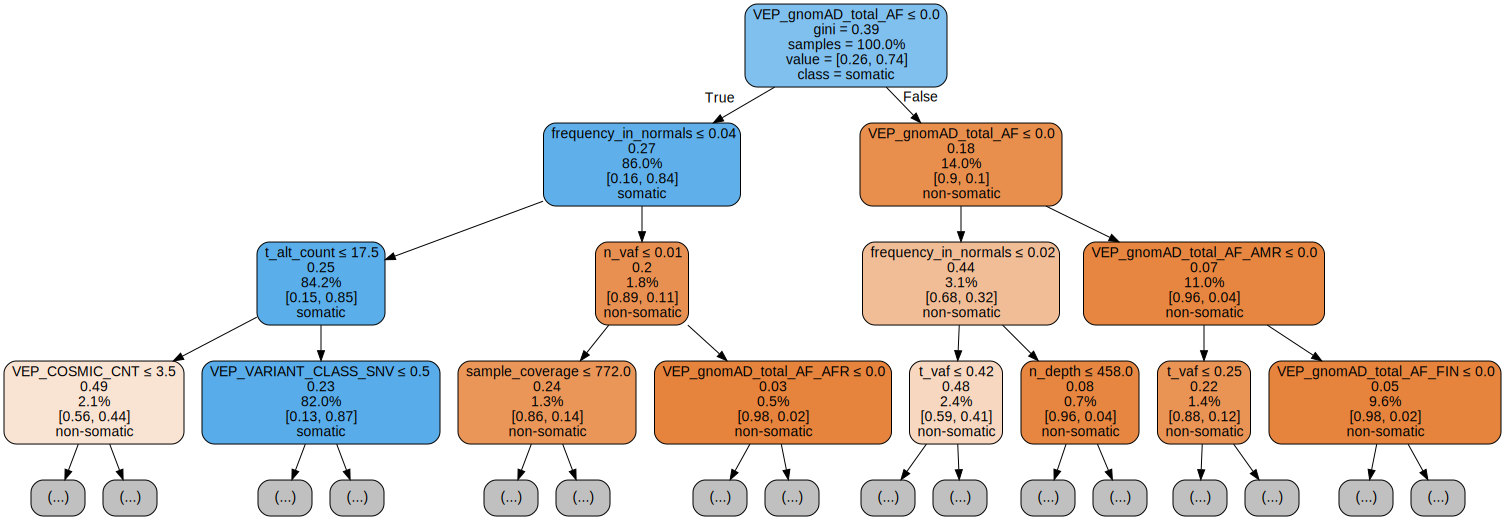

In [208]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 1)
run_model(model_DecisionTreeClassifier, X, y, cv_strategy)

model_DecisionTreeClassifier.fit(X, y)
dot_data = export_graphviz(model_DecisionTreeClassifier, out_file = None, max_depth = 3, feature_names = X.columns.tolist(), class_names = ['non-somatic', 'somatic'], label = 'root', filled = True, proportion = True, rounded = True, special_characters = True, precision = 2) 
graph = graphviz.Source(dot_data) 
graph

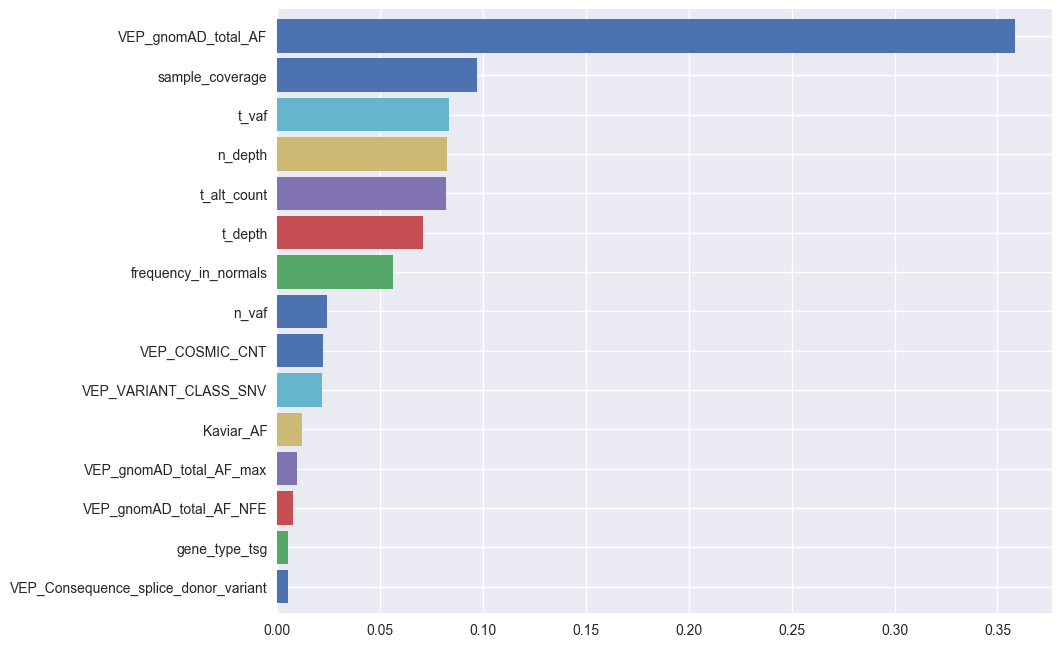

In [209]:
feature_importance = pd.Series(model_DecisionTreeRegressor.feature_importances_.tolist(), index = X.columns.tolist())
feature_importance.sort_values(inplace = True)
feature_importance = feature_importance.tail(15)
feature_importance.plot.barh(figsize = (10, 8), width = 0.85);

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC

parameters_grid = [
    {'C': [0.1, 1, 10], 'kernel': ['poly', 'rbf', 'sigmoid']}
]

model_GS_SVC = GridSearchCV(SVC(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_SVC, X, y, cv_strategy, grid_search = True, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]



## Gradient Boosting

## Other

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = np.linspace(0.1, 1.0, 5), cv = 5)

for i in range(n_folds):
    plt.plot(train_sizes, train_scores[i], linewidth = 0.5, alpha = 0.4, color = 'r',
                     label = 'training score fold %d' % i)
    plt.plot(train_sizes, test_scores[i], linewidth = 0.5, alpha = 0.4, color = 'g',
                     label = 'test score fold %d' % i)
    
train_scores_mean = np.mean(train_scores, axis = 0)
train_scores_std = np.std(train_scores, axis = 0)
test_scores_mean = np.mean(test_scores, axis = 0)
test_scores_std = np.std(test_scores, axis = 0)

plt.plot(train_sizes, train_scores_mean, 'o-r', linewidth = 1,
        label = 'mean training score')
plt.plot(train_sizes, test_scores_mean, 'o-g', linewidth = 1,
         label = 'mean test score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')


plt.xlabel("Training size")
plt.ylabel("Accuracy score")
plt.legend(loc = "lower right", prop = {'size': 5})

Gradient boosting